In [1]:
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox, Layout, widgets
from itertools import cycle
from math import ceil, sqrt
from plotly.graph_objs import FigureWidget, Scatter, Table
from plotly.subplots import make_subplots
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import dtreeviz
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Load the Iris dataset
# iris = datasets.load_iris()
# df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
#                      columns= iris['feature_names'] + ['target'])
df = pd.read_csv('gene_exp.csv')
labels = pd.read_csv('gene_labels.csv')
df['label'] = labels['Class']
df.drop('samples', axis=1, inplace=True)

In [2]:
# create histogram
def create_histograms(df=df, exclude_cols=['target', '_x', '_y'], legend=True):
    """
    Creates histograms of features in selected region and all data
    ---
    Input: Datafame
    Output:
        If dtreeviz_plot=True, then dtreeviz.utils.DTreeVizRender
        Else, None
    ---
    df: Pandas Dataframe of data to analyze
    exclude_cols: Columns not to plot (output and otherwise)
    legend (default True): Whether to show legend on plots
    """
    curr_df = df.drop(exclude_cols, axis=1)
    r = int(sqrt(len(curr_df.columns)))
    c = ceil(len(curr_df.columns) / r)
    # fig = make_subplots(rows=r+1, cols=c+1, column_width=[1/c for _ in range(c + 1)], horizontal_spacing=0.2)
    fig = make_subplots(rows=r+1, cols=c+1)
    col_num =0
    max_cols = len(df.columns)
    for i in range(1, r+1):
        for j in range(1, c+1):
            if col_num < max_cols:
                fig.add_trace(go.Histogram(x=curr_df[curr_df.columns[col_num]], name=curr_df.columns[col_num]), row=i, col=j) 
                fig.add_annotation(xref="x domain",yref="y domain",x=0.5, y=1.2, showarrow=False,
                       text=f"<b>{curr_df.columns[col_num]}</b>", row=i, col=j)
            col_num += 1
    fig.update_layout(margin=dict(l=0, r=0, b=0))
    fig.update_traces(showlegend=legend)
    return fig

In [3]:
def explain_cluster(df, x_cols, num_factors = 10, dtreeviz_plot=True):
    """
    Runs decision tree on selected region and plots feature importance and decision boundaries
    ---
    Input: Pandas Datafame
    Output:
        If dtreeviz_plot=True, then dtreeviz.utils.DTreeVizRender
        Else, None
    ---
    df: Pandas Dataframe of data to analyze
    x_cols: Input columns of df
    dtreeviz_plot: 
     - If True, plots decision tree of selection boundaries using dtreeviz library
     - Else, plots decision tree of selection boundaries using sklearn (faster)
    """
    # Split data into features and target
    X = df[x_cols].values  # replace with the names of the columns you want to use as features
    y = df['_selected'].values  # replace with the name of the target column you want to predict

    # Create and fit a decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(X, y)
    
    feature_importances = clf.feature_importances_
    # Print the feature importances
    # Combine feature names and importances into a list of tuples
    feature_importances = list(zip(x_cols, feature_importances))

    # Sort the list in descending order by feature importance
    feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    # Iterate over the sorted list and print out the feature names and importances
    from ipywidgets import Output, VBox
    print('Feature Importances in Decision Tree')
    for feature_name, importance in feature_importances_sorted[:num_factors]:
        importance_percent = importance * 100
        print(f"{feature_name}: {importance_percent:.2f}%")   
    if dtreeviz_plot:
        viz_model = dtreeviz.model(clf,
                               X_train=X, y_train=y,
                               feature_names=x_cols,
                               target_name=['_selected'], class_names=["not selected", "selected"])
        display(viz_model.view(scale=1.3))
    else:
        out = plot_tree(clf,
           feature_names = x_cols,
           class_names=['not selected', 'selected'],
           filled = True)
        out

In [26]:
def create_lasso(df, mode='table', label_col=None, exclude_cols=[], num_factors = 10, dtreeviz_plot=True):
    """
    Create Lasso tool to analyze lassoed data via below mode options
    ---
    Input: Datafame
    Output: Plotly FigureWidget with lasso select tool
    ---
    data: Pandas Dataframe of data
    exclude_cols: columns to exclude
    mode:
     - 'table' shows a table of selected points
     - 'histogram' shows an interactive histogram selected points
     - 'explainer' predicts which factors lead to clustered selection
    dtreeviz_plot: 
     - If mode = 'explainer' and True, plots decision tree of selection boundaries using dtreeviz library
     - Else, plots decision tree of selection boundaries using sklearn (faster)

    """
    IS_HIST = mode == 'histogram'
    TOP_FACTORS = mode == 'explainer'
    s = widgets.Output()
    pca = PCA(n_components=2)
    pca_cols = [x for x in df.columns if x not in exclude_cols]
    included_cols_df = df[pca_cols]
    pca.fit(included_cols_df)
    pca_df = pd.DataFrame(pca.transform(included_cols_df), columns=['_x', '_y'])
    df['_x'] = pca_df['_x']
    df['_y'] = pca_df['_y']
    
    # Create a FigureWidget
    f = go.FigureWidget()
    f.update_layout(dragmode='lasso')
    f.layout.title = "Data Lasso Scatterplot"

    # If label_col is provided, create a scatter for each unique label
    if label_col is not None:
        # define color cycle
        colors = cycle(plotly.colors.qualitative.Pastel)
        for label in np.unique(df[label_col]):
            df_label = df[df[label_col] == label]
            scatter = go.Scatter(y = df_label["_x"], x = df_label["_y"], mode = 'markers', 
                                 marker=dict(color=next(colors)), name=label)
            f.add_trace(scatter)
        # create layer to perform decision tree on
        scatter = go.Scatter(y = df["_x"], x = df["_y"], mode = 'markers', opacity=0)
        f.add_trace(scatter)
    else:
        # If no label_col is provided, create a single scatter
        scatter = go.Scatter(y = df["_x"], x = df["_y"], mode = 'markers')
        f.add_trace(scatter)

    scatter = f.data[-1]
    df.dropna()
    exclude_cols.extend(['_x', '_y'])

    N = len(df)
    scatter.marker.opacity = 0.5
    t = None
    
    if mode=='table':
        # Create a table FigureWidget that updates on selection from points in the scatter plot of f
        t = FigureWidget([Table(
            header=dict(values=df.columns,
                        fill = dict(color='#C2D4FF'),
                        align = ['left'] * 5),

            cells=dict(values=[df[col] for col in df.columns],
                    fill = dict(color='#F5F8FF'),
                    align = ['left'] * 5
                    ))])
    if IS_HIST:
        hist = create_histograms(df, exclude_cols=exclude_cols, legend=True)
        no_legend = create_histograms(df, exclude_cols=exclude_cols)
        # t is for "table", but can also be where data is
        t = go.FigureWidget(no_legend, )
        t.layout.title = 'All Points'
        # s is selected
        s = go.FigureWidget(hist)
        s.layout.title = 'Selected Points'
    if TOP_FACTORS:
        pass
    def selection_fn(trace,points,selector):
        nonlocal s
        if mode=='table':
            t.data[0].cells.values = [df.loc[points.point_inds][col] for col in df.columns]
        if IS_HIST:
            selected = df[df.index.isin(points.point_inds)]
            new_charts = create_histograms(selected, exclude_cols=exclude_cols, legend=True)
            s.data = []
            s.add_traces(new_charts.data)
        if TOP_FACTORS:
            df['_selected'] = df.index.isin(points.point_inds)
            x_cols = list(filter(lambda x: x not in exclude_cols and x != '_selected', df.columns))
            with s:
                clear_output(wait=True)
            out = explain_cluster(df, x_cols, num_factors, dtreeviz_plot=dtreeviz_plot)    
    scatter.on_selection(selection_fn)

    # Put everything together
    if IS_HIST:
        return VBox((f, s, t), layout=Layout(align_items='flex-start', margin='0px', justify_content='center'))
    return VBox(tuple(x for x in [f, s, t] if x))

(Scatter({
    'mode': 'markers',
    'uid': 'e69718e5-a02c-4940-a209-41fe5badc2b8',
    'x': array([-312.00192374,  300.43921868,  -26.74665878, ...,   71.5416385 ,
                -306.43934338, -169.13941958]),
    'y': array([-208.13690779,   -8.06857722, -236.36534798, ...,   34.779146  ,
                -182.62605462, -162.85644916])
}),)


    'data': [{'marker': {'opacity': 0.5},
              'mode': 'markers',
     …

Feature Importances in Decision Tree
gene_9176: 95.44%
gene_7787: 3.63%
gene_5317: 0.93%
gene_0: 0.00%
gene_1: 0.00%
gene_2: 0.00%
gene_3: 0.00%
gene_4: 0.00%
gene_5: 0.00%
gene_6: 0.00%


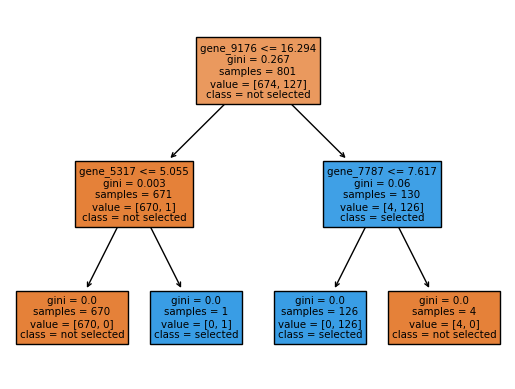

In [28]:
create_lasso(df, mode='explainer', label_col='label', exclude_cols=['label'], dtreeviz_plot=False)

In [23]:
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,label,_x,_y,_selected
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD,-177.499119,-266.075721,False
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD,-6.881270,256.215452,False
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD,-201.573100,-22.810155,False
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD,-239.767989,-207.166916,False
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA,-196.745875,-27.189501,False


In [ ]:
# add svm visualization - project the decision boundary down to 2d
# - want PCA acconting for actual data and SVM line
# - look at gene expression dataset
# - later counterfactual explanations
# - another idea: what if you have a graph and you select one dimension and PCA the other...
# - could also add color as another dimension